# DCR Research - Assingment 2
Astronomy 499: (Winter 2022)

In [1]:
import numpy as np
import scipy.constants as const
import matplotlib
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.units import cds
cds.enable()
import pandas as pd

## From Assignment 1

In [2]:
latitude = -30.24463 * u.deg
longitude = -70.74942 * u.deg
altitude = 2647 * u.m
p0 = 101325 * u.Pa # sea level air presssure
g = const.g * (u.m/u.s**2)
R0 = 8.31447 * u.J/(u.mol*u.K) # gas constant
T0 = 19. * u.deg_C # typical sea level temperature
lapseRate = -6.5 * (u.deg_C/u.km) # typical rate of change of temperature with altitude
M = 0.0289644 * (u.kg/u.mol) # molar mass of dry air
humidity = 40. # typical humidity at many ovservatory sites

In [3]:
temperature = T0 + (lapseRate * altitude)
temperatureK = temperature.to(u.K, equivalencies = u.temperature())

pressure = (p0 * np.exp((-g * M * altitude) / (R0 * temperatureK))).to(u.Pa)

In [4]:
# calculating the water-vapor pressure (mm)
def power_vapor_pressure(temp, RH):
    t = temp.value
    x = np.log(RH/100)
    tdC_numerator = (((t + 238.3)*x) + (17.2694 * t))
    tdC_demoninator = ((t + 238.3) * (17.2694 - x)) - (17.2694 * t)
    tdC = (238.3 * (tdC_numerator/tdC_demoninator)) * u.deg_C
    t_dewpoint_C = tdC.value
    pressure = (4.50874 + (0.341724 * t_dewpoint_C) + (0.0106778 * t_dewpoint_C**2) + (0.184889e-3 * t_dewpoint_C**3) + (0.238294e-5 * t_dewpoint_C**4) + (0.203447e-7 * t_dewpoint_C**5)) * u.cds.mmHg
    return pressure

p_w = (power_vapor_pressure(temperature, humidity)).to(u.cds.mbar)
p_s = pressure.to(u.cds.mbar)
zin = 30 * u.deg

In [5]:
# Using Equations: 4, 5, 9, 10, 14, 15, 16, 18, 20, 21 + 2

def gammafunction(wavelength, Ps_in, Tinitial, Pw_in):
    T = Tinitial.to(u.K, equivalencies = u.temperature()).value
    sigma = 1/wavelength.to(u.um).value
    
    Ps = Ps_in.to(u.cds.mbar).value
    Pw = Pw_in.to(u.cds.mbar).value
    
    Ds = (1 + (Ps * (57.90e-8 - (9.3250e-4/T) + (0.25844/T**2)))) * (Ps/T)
    Dw = (1 + (Pw * (1 + 3.7e-4 * Pw) * (-2.37321e-3 + ((2.23366/T)-(710.792/T**2) + (7.75141e4/T**3))))) * (Pw/T)
    term_one = (2371.34 + (683939.7/(130 - sigma**2)) + (4547.3/(38.9 - sigma**2))) * Ds
    term_two = ((6487.31 + (58.058 * sigma**2) - (0.71150 * sigma**4) + (0.08851 * sigma**6))) * Dw
    n = ((term_one + term_two) / (1e8))
    return n

def calc_beta(tin):
    t = tin.value
    beta = 0.001254 * ((273.15 + t)/273.15)
    return beta

def calc_kappa(phi_degrees, height): # 10
    phi = phi_degrees.to(u.rad).value
    h = height.value
    kappa = 1 + (0.005302 * (np.sin(phi)**2)) - (0.00000583 * (np.sin(2 * phi)**2)) - (0.000000315 * h)
    return kappa
    
# Atmospheric refraction
def atm_refraction(wavelength, Ps, Tinitial, Pw, phi, h, z0):
    gamma = gammafunction(wavelength, Ps, Tinitial, Pw)
    beta = calc_beta(Tinitial)
    kappa = calc_kappa(phi , h)
    
    refraction = (kappa * gamma * (1 - beta) * np.tan(z0.to(u.rad))) - (kappa * gamma * (beta - (gamma / 2)) * (np.tan(z0.to(u.rad))**3))
    
    return refraction
    
    

In [6]:
rad2arcsec = (206265 * u.arcsec) # conversion between radians and arcseconds

In [7]:
# Import Data

# g-band
gband = pd.read_csv('total_g.dat', delimiter = " ", comment = "#", header=None, skipinitialspace = True)
gband_wavelength = np.array(gband[0]) * u.nm
gband_throughput = np.array(gband[1])

# i-band
iband = pd.read_csv('total_i.dat', delimiter = " ", comment = "#", header=None, skipinitialspace = True)
iband_wavelength = np.array(iband[0]) * u.nm
iband_throughput = np.array(iband[1])

# General
column_names = ['Wave', 'FluxD', 'e_FluxD'] #, 'None1', 'None2', 'None3', 'None4', 'None5', 'None6', 'None7', 'None8']
simulatedquasarspectrum = pd.read_csv('Vanden_Berk_quasars.txt', delimiter = " ", header=None, skipinitialspace = True, names = column_names, skiprows=23)
subsection = simulatedquasarspectrum
subsection = simulatedquasarspectrum.apply(pd.to_numeric, errors='coerce')

data = subsection[['Wave', 'FluxD', 'e_FluxD']]

In [8]:
# Wavelength
wavelength_or = np.array(subsection['Wave']) * u.Angstrom
wavelength_nm = (wavelength_or[23:]).to(u.nm)

# Relative Flux Density
relative_fluxdensity = subsection['FluxD'][23:]

In [9]:
# Defining Redshift Function
def redshift(z, spectrum_wavelength):
    redshiftspectrum = (1 + z) * spectrum_wavelength
    return redshiftspectrum

# Redshifts
spectra_obs = [wavelength_nm, redshift(1.0, wavelength_nm), redshift(1.5, wavelength_nm), redshift(2.0, wavelength_nm), redshift(2.5, wavelength_nm)]


In [10]:
# Calculate the effective wavelength

gWeightedWavelength = np.average(gband_wavelength[0:7755], weights = gband_throughput[0:7755])
iWeightedWavelength = np.average(iband_wavelength[0:7755], weights = iband_throughput[0:7755])


In [11]:
gWeightedWavelength

<Quantity 480.00048773 nm>

In [12]:
iWeightedWavelength

<Quantity 754.22199777 nm>

## Part 1: Basic Point Spread Function (PSF) Modeling

### Part 1a 

Recall the 2D gaussian modeling from last quarter. In a 32X32 pixel numpy array, plot a 2D gaussian with a Full Width Half Maximum (FWHM) of 0.8 arcseconds, using 0.26 arcseconds per pixel. The gaussian should be centered on pixel (16, 16). Verify the result with a 1D plot of the values along the y-axis through the center of the gaussian.

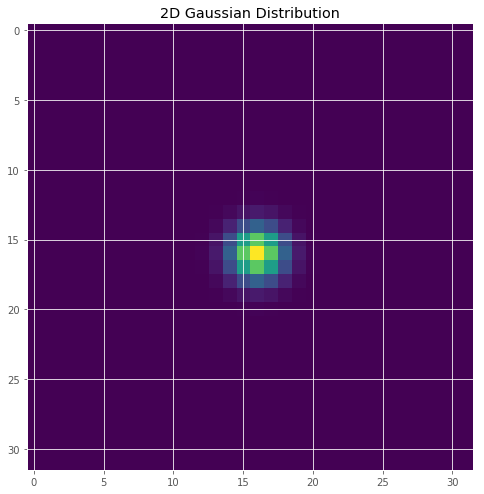

In [13]:
# Convert from fwhm to sigma
fwhm_conversion = 2 * np.sqrt(2 * np.log(2))

# Creating 2D Gaussian Functions
def gaussian2d(x_dimension = 32, y_dimension = 32, xcenter = 16, ycenter = 16, sigmax = (0.8/0.26)/fwhm_conversion, sigmay = (0.8/0.26)/fwhm_conversion):
    x = np.linspace(0, x_dimension-1, x_dimension)
    y = np.linspace(0, y_dimension-1, y_dimension)
    x, y = np.meshgrid(x, y)
    
    diffx = x - xcenter
    diffy = y - ycenter
    gaussian = np.exp(-((diffx**2/(2*sigmax**2))+(diffy**2/(2*sigmay**2))))
    
    return gaussian

# Defining X, Y & Gaussian Values
gaussian_2d = gaussian2d()

# Plot of Gaussian Distribution
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize = (8, 24))
ax.imshow(gaussian_2d)
ax.set_title('2D Gaussian Distribution');

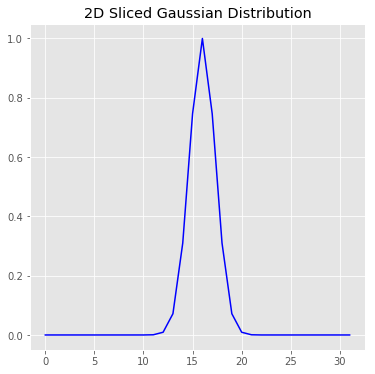

In [14]:
# Verify with 1D Plot (slice of numpy array at x = 16)
sliced_gaussian = gaussian_2d[:,16] #y, x

# Plot
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.plot(sliced_gaussian, color = 'b')
ax.set_title('2D Sliced Gaussian Distribution');

### Part 1b 

Write a function to plot a 2D gaussian at an arbitrary offset from the center. The function should add the new gaussian to an existing image, and should take the FWHM of the gaussian and the flux as keyword parameters.

In [15]:
def offset_2dgaussian(fwhm, flux, xoffset, yoffset, xcenter, ycenter):
    
    sigma = fwhm / 0.26
    gaussian = gaussian2d(x_dimension=32, y_dimension=32, xcenter=xcenter, ycenter=ycenter+yoffset, sigmax=sigma, sigmay=sigma)
    gaussian /= np.sum(gaussian)
    
    return gaussian*flux 

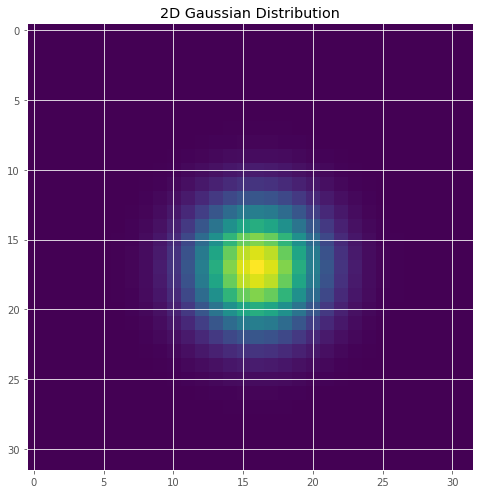

In [16]:
# Plot of Gaussian Distribution
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize = (8, 24))
temp = offset_2dgaussian(.8, 2.3456, 0,1,16,16)
ax.imshow(temp)
ax.set_title('2D Gaussian Distribution');

## Part 2: Model An Observed Quasar

### Part 2a 

Take the quasar spectrum from 2a and the DCR calculation from 3b of assignment 1. For each wavelength (at 1nm resolution) use your function from 1b above to model the total observed quasar image. Recall that the *differential* shift is relative to the refraction at the effective wavelength of the band. Use 0.26 arcseconds/pixel as the platescale of the image, and assume the shift is purely along the y-axis. Use a quasar at redshift 2.5, the same observing conditions as in assignment 1, and make images for both g- and i-bands.

In [17]:
def totalImage(band_wavelength, band_throughput, observed_spectra, relative_fluxdensity, WeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin, fwhm, xcenter, ycenter):
    image_comp = np.zeros((32, 32), ) # float by default
    refractionindex_eff = atm_refraction(WeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin)
    yoffset_value = []
    
    fmin = max(band_throughput)*.01
    w_use = []
    for w,f in zip(band_wavelength, band_throughput):
        if f < fmin:
            continue
        w_use.append(w.value)
        
        # calculate flux - 2a
        interpolate = np.interp(w, observed_spectra, relative_fluxdensity)
        flux = f * interpolate
        
        # dcr shift - 3b
        refraction = atm_refraction(w, p_s, temperature, p_w, latitude, altitude, zin)
        yoffset = (refraction - refractionindex_eff)* rad2arcsec.value / 0.26
        yoffset_value.append(yoffset)
        xoffset = 0 / 0.26 # shift purely in the y-direction
        
        # creating gaussian
        newgaussian = offset_2dgaussian(fwhm, flux, xoffset, yoffset, xcenter, ycenter)
        image_comp += newgaussian.value

    fig, ax = plt.subplots(1, 1, figsize = (6, 6))
    im = ax.imshow(image_comp)
    fig.colorbar(im, orientation = 'vertical')
    ax.set_title('2D Offset Gaussian Distribution');  
    
    return w_use, yoffset_value, image_comp

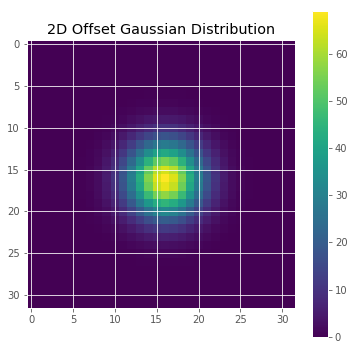

In [18]:
# G-Band Image
g_wls, gimage, gdistribution = totalImage(gband_wavelength, gband_throughput, spectra_obs[4], relative_fluxdensity, gWeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin, 0.8, 16, 16)



In [19]:
min(gimage)

<Quantity -0.69517074>

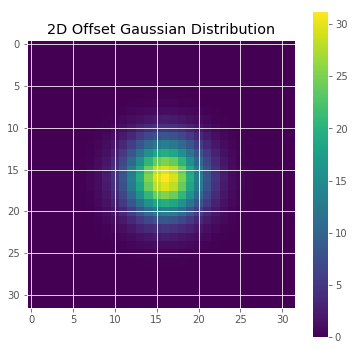

In [20]:
# I-Band Image
w_use, iimage, idistribution = totalImage(iband_wavelength, iband_throughput, spectra_obs[4], relative_fluxdensity, iWeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin, 0.8, 16, 16)


### Part 2b 

As in 1a, verify the results of 2a with 1D plots of the values of the images along the y-axis through the center of the image (this should be aligned with the direction of the DCR shifts from 2a).

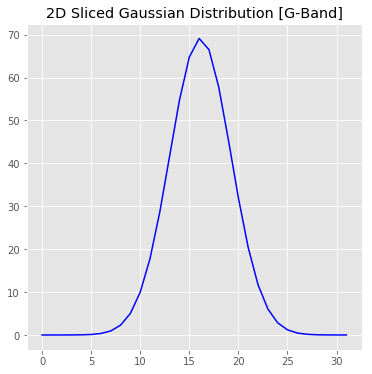

In [21]:
# G-Band 1D plot check
sliced_gtotal = gdistribution[:,16] #y, x

type(gimage[0])


# Plot
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.plot(sliced_gtotal, color = 'b')
ax.set_title('2D Sliced Gaussian Distribution [G-Band]');

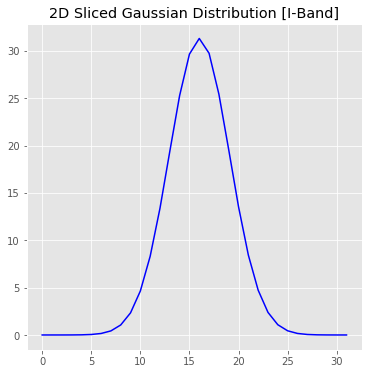

In [22]:
# I-Band 1D plot check
sliced_itotal = idistribution[:,16] #y, x

type(iimage[0])

# Plot
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.plot(sliced_itotal, color = 'b')
ax.set_title('2D Sliced Gaussian Distribution [I-Band]');